In [1]:
import torch
import numpy as np
import pandas as pd
import helper_functions as hf
from dataloader import JPXData
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataloader import default_collate
from torchvision import transforms
from statistics import mean
from tqdm import tqdm
import itertools

pd.set_option('display.max_rows', 100)
torch.set_printoptions(profile="default")
device = "cuda" if torch.cuda.is_available() else "cpu"

/home/aymane/Kaggle/jpx-2022/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/aymane/Kaggle/jpx-2022/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# Run this to create the new modified_data folder
# ~ 1 min runtime

# hf.concat_data()

# Run this to tokenize Section/Product and NewMarketSegmentColumns on stock_list.csv
# ~ 20 secs runtime

# hf.tokenize_stock_list()

# Run this to adjust the closing price
# ~ 2 mins runtime

# hf.adjust_price()

In [3]:
stock_prices = pd.read_csv("modified_data/stock_prices_adjusted.csv")

In [4]:
# ~ 3 month testing time frame 2022-01-04 to 2022-04-28
train_data = stock_prices[stock_prices["Date"] < '2022-01-04'].copy().reset_index(drop=True)
test_data  = stock_prices[stock_prices["Date"] >= '2022-01-04'].copy().reset_index(drop=True)

2370531 157993
2528524


In [5]:
train_class = JPXData(data=train_data)
trainloader = torch.utils.data.DataLoader(train_class, batch_size=1, shuffle=True, num_workers=5)
test_class  = JPXData(data=test_data, train=False)
testloader  = torch.utils.data.DataLoader(JPXData(data=test_data), batch_size=1, shuffle=False, num_workers=5)

In [6]:
# Ranking Securities Codes by rate of change from t+1 to t+2
stock_prices = pd.read_csv("modified_data/stock_prices.csv")
date = "2017-01-04"
targets = stock_prices.query("Date == @date")[["Target", "SecuritiesCode"]].fillna(0)
df = targets.sort_values(by="Target")
df

,Target,SecuritiesCode
1733,-0.069874,9474
1856,-0.067387,9983
1136,-0.062112,6875
1852,-0.059276,9974
1078,-0.057514,6707
...,...,...
1695,0.094378,9233
404,0.098553,3547
1000,0.104668,6425
1297,0.106332,7600


In [7]:
a = train_class
print(a[0])

(tensor([-0.8932, -0.1361,  0.3141,  ...,  0.6294, -1.1694, -0.7577]), tensor([ 0.0007,  0.0123,  0.0062,  ...,  0.0150, -0.0011,  0.0075]), ['2017-01-04'])


In [8]:
a = test_data.groupby("Date").size() 
print(a)

Date
2022-01-04    2000
2022-01-05    2000
2022-01-06    2000
2022-01-07    2000
2022-01-11    2000
2022-01-12    2000
2022-01-13    2000
2022-01-14    2000
2022-01-17    2000
2022-01-18    2000
2022-01-19    2000
2022-01-20    2000
2022-01-21    2000
2022-01-24    2000
2022-01-25    2000
2022-01-26    2000
2022-01-27    2000
2022-01-28    2000
2022-01-31    2000
2022-02-01    2000
2022-02-02    2000
2022-02-03    2000
2022-02-04    2000
2022-02-07    2000
2022-02-08    2000
2022-02-09    2000
2022-02-10    2000
2022-02-14    2000
2022-02-15    2000
2022-02-16    2000
2022-02-17    2000
2022-02-18    2000
2022-02-21    2000
2022-02-22    2000
2022-02-24    2000
2022-02-25    2000
2022-02-28    2000
2022-03-01    2000
2022-03-02    2000
2022-03-03    2000
2022-03-04    2000
2022-03-07    2000
2022-03-08    2000
2022-03-09    2000
2022-03-10    2000
2022-03-11    2000
2022-03-14    2000
2022-03-15    2000
2022-03-16    2000
2022-03-17    2000
2022-03-18    2000
2022-03-22    2000
2022-03

In [9]:
# # Verifying if the ranking is the same
# securities_codes    = stock_prices["SecuritiesCode"]
# securities_list     = sorted(list(set(securities_codes)))
# securities_dict     = {i: securities_list.index(i) for i in securities_list}

# a = dataloader[0][1]
# sorted_args = torch.argsort(a, descending=True)
# securities_sort = [list(securities_dict.keys())[list(securities_dict.values()).index(i)] for i in sorted_args]
# print(securities_sort)

In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(2000, 2500),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Linear(2500, 1500),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Linear(1500, 1000),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Linear(1000, 1500),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Linear(1500, 2000),
        )

    def forward(self, x):
        output = self.layer_stack(x)
        return output

In [12]:
net = Net().cuda()

RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

In [ ]:
criterion = nn.MSELoss().cuda()
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)

In [ ]:
loss_a1 = []

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, date = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = hf.loss_function(outputs * 10, labels * 10, criterion=nn.HuberLoss(delta=5))
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(net.parameters(), 1.5)
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        loss_a1.append(running_loss)
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.10f}')
            running_loss = 0.0
        # torch.save(net.state_dict(), f'saved_models/{epoch}.pt')

print('Finished Training')

[1,   100] loss: 0.0018934137
[1,   200] loss: 0.0013483496
[1,   300] loss: 0.0014332096
[1,   400] loss: 0.0015621669
[1,   500] loss: 0.0015570167
[1,   600] loss: 0.0013128131
[1,   700] loss: 0.0014049261
[1,   800] loss: 0.0013596762
[1,   900] loss: 0.0014832263
[1,  1000] loss: 0.0013873086
[1,  1100] loss: 0.0013539492
[1,  1200] loss: 0.0012562470
[2,   100] loss: 0.0016429460
[2,   200] loss: 0.0013551116
[2,   300] loss: 0.0013848762
[2,   400] loss: 0.0014038488
[2,   500] loss: 0.0015039636
[2,   600] loss: 0.0015376102
[2,   700] loss: 0.0014714891
[2,   800] loss: 0.0011933568
[2,   900] loss: 0.0013591025
[2,  1000] loss: 0.0012396148
[2,  1100] loss: 0.0011590920
[2,  1200] loss: 0.0012061297
Finished Training


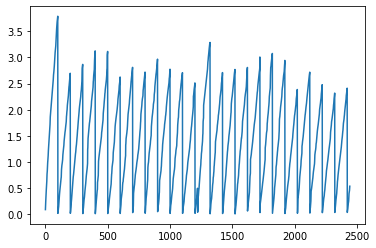

In [ ]:
plt.plot(loss_a1)
plt.show()

In [ ]:
pred_df = pd.DataFrame()
dates = []
securities = []
preds = []
targets = []

stock_ids = test_class.stock_id.tolist()

for X, target, date in tqdm(test_class):
    X = X.cuda()
    pred = net(X)

    target_list = target.tolist()

    dates.append(date*2000)
    securities.append(stock_ids)
    preds.append(pred.tolist())
    targets.append(target_list)

    new_dates = list(itertools.chain.from_iterable(dates))
    new_securities = list(itertools.chain.from_iterable(securities))
    new_preds = list(itertools.chain.from_iterable(preds))
    new_targets = list(itertools.chain.from_iterable(targets))

pred_df["Date"] = new_dates
pred_df["SecuritiesCode"] = new_securities
pred_df["Prediction"] = new_preds
pred_df["Target"] = new_targets
print(pred_df)
# predictions = pd.DataFrame(list(zip(dates, securitiescodes, targets)), columns=["Date", "SecuritiesCode", "Target"]

100%|██████████| 79/79 [00:00<00:00, 374.82it/s]

              Date  SecuritiesCode  Prediction    Target
0       2022-01-04            1301    0.006119 -0.011254
1       2022-01-04            1332    0.007194 -0.017857
2       2022-01-04            1333   -0.013367 -0.017087
3       2022-01-04            1375   -0.004882 -0.008210
4       2022-01-04            1376   -0.001395 -0.003968
...            ...             ...         ...       ...
157995  2022-04-28            9990    0.002067  0.024048
157996  2022-04-28            9991    0.001737  0.011378
157997  2022-04-28            9993   -0.005027 -0.005941
157998  2022-04-28            9994   -0.000009  0.005602
157999  2022-04-28            9997    0.004830 -0.013680

[158000 rows x 4 columns]


In [ ]:
dates = pred_df.groupby("Date")

securities_dict = {i: stock_ids.index(i) for i in stock_ids}
rank = []
for i in tqdm(dates):
    sorted_args = torch.argsort(torch.tensor(list(i[1]["Prediction"])), descending=True)
    securities_sort = [list(securities_dict.keys())[list(securities_dict.values()).index(i)] for i in sorted_args]
    sorted_ranks = [securities_sort.index(i) for i in stock_ids]
    rank.append(sorted_ranks)

new_rank = list(itertools.chain.from_iterable(rank))
pred_df["Rank"] = new_rank

  0%|          | 0/79 [00:04<?, ?it/s]


NameError: name 'securities_list' is not defined

In [ ]:
pred_df
# pred_df.drop(columns=["Prediction"])

,Date,SecuritiesCode,Prediction,Target,Rank
0,2022-01-04,1301,0.006119,-0.011254,1775
1,2022-01-04,1332,0.007194,-0.017857,6875
2,2022-01-04,1333,-0.013367,-0.017087,4574
3,2022-01-04,1375,-0.004882,-0.008210,8219
4,2022-01-04,1376,-0.001395,-0.003968,7094
...,...,...,...,...,...
157995,2022-04-28,9990,0.002067,0.024048,8628
157996,2022-04-28,9991,0.001737,0.011378,4538
157997,2022-04-28,9993,-0.005027,-0.005941,9434
157998,2022-04-28,9994,-0.000009,0.005602,8016


In [ ]:
hf.calc_spread_return_sharpe(pred_df)

min: 1301, max: 9997


AssertionError: 

In [ ]:
print(pred_df)

In [ ]:
# Verifying if the ranking is the same
securities_codes    = stock_prices["SecuritiesCode"]
securities_list     = sorted(list(set(securities_codes)))
securities_dict     = {i: securities_list.index(i) for i in securities_list}
submission = pd.DataFrame()
dates = sorted(list(set(pd.to_datetime(stock_prices["Date"]).dt.date)))

a = train_class[0][1]
sorted_args = torch.argsort(a, descending=True)
securities_sort = [list(securities_dict.keys())[list(securities_dict.values()).index(i)] for i in sorted_args]
print(securities_sort)

In [ ]:
date = dates[0]
submission["Date"] = [date.strftime("%Y-%m-%d")] * len(securities_sort)
submission["SecuritiesCode"] = securities_list
submission["Rank"] = [securities_sort.index(i) for i in securities_list]

In [ ]:
print(submission)

In [ ]:
close_prices = train_class[0][0]
close_prices = close_prices.cuda()
net_out = net(close_prices)

print(net_out)

sample_prediction = pd.DataFrame()

sorted_args = torch.argsort(net_out, descending=True)
securities_sort = [list(securities_dict.keys())[list(securities_dict.values()).index(i)] for i in sorted_args]

sample_prediction["Rank"] = [securities_sort.index(i) for i in securities_list]
print(submission)